In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

C:\Users\mia\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
summary_df = pd.read_csv(r'''C:\Users\mia\Documents\Python Scripts\relax_challenge\takehome_user_engagement.csv''')

In [3]:
user_df = pd.read_csv(r'''C:\Users\mia\Documents\Python Scripts\relax_challenge\takehome_users.csv''', encoding='latin-1')

In [4]:
summary_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
summary_df.time_stamp = pd.to_datetime(summary_df.time_stamp)

In [6]:
summary_df['date'] = summary_df.time_stamp.dt.normalize()

### Create target variable, 'adopted'
***
Grouping on ‘user_id’ and rolling the window with a frequency of 7 days gives the counts of logins in 7 days for each user.

In [7]:
groups = pd.DataFrame(summary_df.sort_values('date').groupby('user_id').rolling('7D',on='date').visited.sum())
groups.head(20)

visited
user_id date               
1       2014-04-22      1.0
2       2013-11-15      1.0
        2013-11-29      1.0
        2013-12-09      1.0
        2013-12-25      1.0
        2013-12-31      2.0
        2014-01-08      1.0
        2014-02-03      1.0
        2014-02-08      2.0
        2014-02-09      3.0
        2014-02-13      3.0
        2014-02-16      2.0
        2014-03-09      1.0
        2014-03-13      2.0
        2014-03-31      1.0
3       2013-03-19      1.0
4       2013-05-22      1.0
5       2013-01-22      1.0
6       2013-12-19      1.0
7       2012-12-20      1.0

In [8]:
adopted_users = groups.loc[groups.visited >= 3].index.get_level_values('user_id').unique()

In [9]:
print('There are total ',len(adopted_users),' adopted users in this sample.')

There are total  1602  adopted users in this sample.


In [10]:
user_df['adopted'] = user_df.object_id.apply(lambda x: 1 if x in adopted_users else 0 )

In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


### Process Factors Data

In [12]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


#### Process Missing Values 
***
`invited_by_user——id` does not give any useful information in addition to the variable `creation_source`, so it will be dropped and no need filling the missings.
I will fill NaNs in `last_session_creation_time` with mean, but before doing that, I would like to see how the 'real' `last_session_creation_time` is distributed.

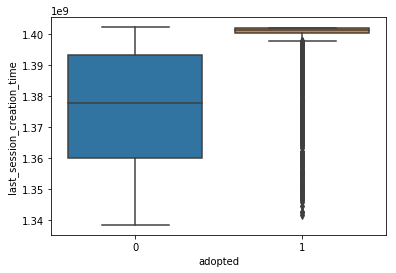

In [13]:
sns.boxplot(x='adopted',y='last_session_creation_time',data=user_df)

In [14]:
# Fill NaNs in `last_session_creation_time` with mean
user_df.last_session_creation_time.fillna(user_df.last_session_creation_time.mean(),inplace=True)

### EDA

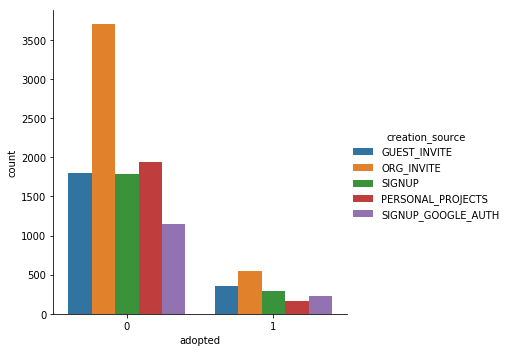

In [15]:
sns.catplot(x='adopted',hue='creation_source',kind='count',data=user_df)

The creation sources distribute similarily in the 'adopted' users group and the 'unadopted' users group. Both majority users signed up because they are invited to an organization. The second two sources for two groups are both invited to an organization as a guest and signing up via the website.

In [16]:
user_df['date'] = pd.to_datetime(user_df.creation_time).dt.normalize()

In [17]:
user_df['month'] = user_df.date.dt.month

In [18]:
user_df['day'] = user_df.date.dt.weekday

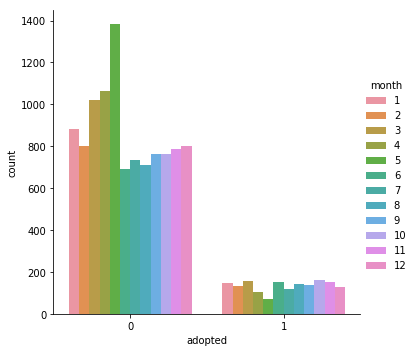

In [19]:
sns.catplot(x='adopted',hue='month',kind='count',data=user_df)

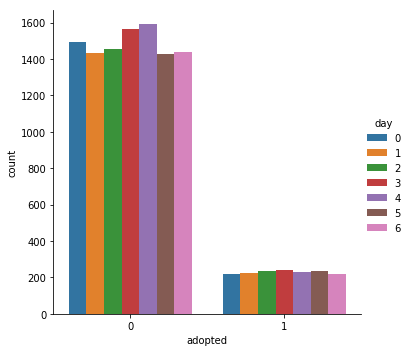

In [20]:
sns.catplot(x='adopted',hue='day',kind='count',data=user_df)

### Feature Selection
***

Many variables in the dataset are not useful to identify whether users are adopted just by their descriptions, such as `name`,`email`, `org_id`,`invited_by_user_id`, and `object_id`. Those will be dropped. Some potential predicitive factors are generated from transforming the existed variables, for example `month` and `day` (the day of a week) are created from `creation_time`. I also want to create a factor, the time interval between the `creation_time` and `lass_session_creation_time`, but I need some specific information on the `creation_time` variable, such as what time zone it is referring to, to make sure get the correct time intervals. Hence, I will drop the `lass_session_creation_time` variable for now. Then, I will encode the selected categorical variables.

In [21]:
X = pd.get_dummies(user_df.loc[:,['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','day','month']])

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
day                                   12000 non-null int64
month                                 12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
dtypes: int64(4), uint8(5)
memory usage: 433.7 KB


In [23]:
y = user_df.adopted

In [25]:
clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  

array([0.06248692, 0.06829428, 0.36222849, 0.43136061, 0.01278916,
       0.01197761, 0.0246989 , 0.01196273, 0.0142013 ])

In [26]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
month,0.431361
day,0.362228
enabled_for_marketing_drip,0.068294
opted_in_to_mailing_list,0.062487
creation_source_PERSONAL_PROJECTS,0.024699
creation_source_SIGNUP_GOOGLE_AUTH,0.014201
creation_source_GUEST_INVITE,0.012789
creation_source_ORG_INVITE,0.011978
creation_source_SIGNUP,0.011963


It looks like the factors, `day` and `month` has the most significance on predicting whether users are adopted or not. The five factors related to `creation_source` have the least importance on prediction.